# Part III: Model Training for Left Right Fingerprints

This tutorial is based on the [TensorFlow Image Classification](https://www.tensorflow.org/tutorials/images/classification) with some modifications, which shows how to classify images of fingerprints using a tf.keras.Sequential model and load data using tf.keras.utils.image_dataset_from_directory. 

This tutorial follows a basic machine learning workflow:

1. Examine and understand data
1. Build an input pipeline
1. Build the model
1. Train the model
1. Test the model
1. Improve the model and repeat the process

The workflow above spans multiple notebooks
1. data exploration
1. data preprocessing 
1. model training
1. model tuning

## Setup

Import TensorFlow and other necessary libraries:

In [20]:
! pip install -r ../requirements.txt -q

In [44]:
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import os
import cv2

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

## Check TF and Cuda versions

For reference [see this chart](https://www.tensorflow.org/install/source#gpu)

In [22]:
# check versions for Tensorflow and Cuda
print('TensorFlow: ' + tf.__version__)
print('TensorFlow Datasets: ' + tfds.__version__)
print('OpenCV version: ' + cv2.__version__)

# Check CUDA Version
sys_details = tf.sysconfig.get_build_info()
cuda_version = sys_details["cuda_version"]
print('Cuda version: ' + cuda_version)

# Check CUDNN Version
cudnn_version = sys_details["cudnn_version"]  
print('cudnn version: ' + cudnn_version)

TensorFlow: 2.14.0
TensorFlow Datasets: 4.9.3
OpenCV version: 4.8.1
Cuda version: 11.8
cudnn version: 8


In [23]:
# scratch directory is apart of the .gitignore to ensure it is not committed to git
%env SCRATCH=../scratch
! [ -e "${SCRATCH}" ] || mkdir -p "${SCRATCH}"

scratch_path = os.environ.get('SCRATCH', './scratch')

env: SCRATCH=../scratch


# Create dataset

Define some parameters for the loader

In [24]:
batch_size = 32
img_height = 96
img_width = 96

## Create the training dataset

It's good practice to use a validation split when developing your model. Use 80% of the images for training and 20% for validation.

In [25]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  scratch_path + '/processed/',
  #color_mode="grayscale",
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 17955 files belonging to 2 classes.
Using 14364 files for training.


## Create the validation dataset

In [26]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  scratch_path + '/processed/',
  #color_mode="grayscale",
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 17955 files belonging to 2 classes.
Using 3591 files for validation.


## Print the inferred class names

You can find the class names in the class_names attribute on these datasets. These correspond to the directory names in alphabetical order.

In [27]:
class_names = train_ds.class_names
print(class_names)

['left', 'right']


## Visualize the data

Here are the first nine images from the training dataset with their corresponding labels.

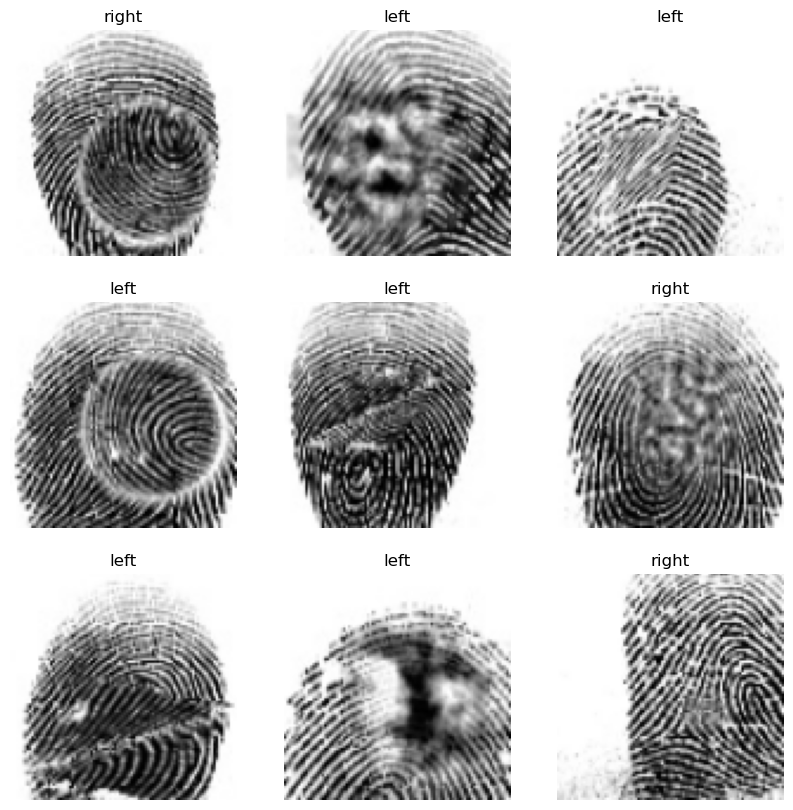

In [28]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

Pass the datasets to the Keras Model.fit method for training in later steps.

Use the image_batch tensor of  shape (32, 96, 96, 3), which splits batch of 32 images of shape 96x96x3 (the last dimension refers to color channels RGB). The label_batch is a tensor of the shape (32,), these are corresponding labels to the 32 images.

In [29]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 96, 96, 3)
(32,)


## Configure the dataset for performance

We can use buffered prefetching, to yield data from disk without having I/O become blocking. These are two important methods you should use when loading data:

1. `Dataset.cache` keeps the images in memory after they're loaded off disk during the first epoch. This will ensure the dataset does not become a bottleneck while training your model. If your dataset is too large to fit into memory, you can also use this method to create a performant on-disk cache.
1. `Dataset.prefetch` overlaps data preprocessing and model execution while training.

In [30]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [31]:
strategy = tf.distribute.MirroredStrategy()

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1', '/job:localhost/replica:0/task:0/device:GPU:2', '/job:localhost/replica:0/task:0/device:GPU:3')


In [32]:
print('Number of devices: {}'.format(strategy.num_replicas_in_sync))

Number of devices: 4


In [33]:
# cuda_malloc_async has fewer fragmentation issues than the default BFC memory allocator - https://docs.nvidia.com/deeplearning/frameworks/tensorflow-user-guide/index.html#tf_gpu_allocator
TF_FORCE_GPU_ALLOW_GROWTH=True

os.environ["TF_GPU_ALLOCATOR"] = "cuda_malloc_async"
print(os.getenv("TF_GPU_ALLOCATOR"))

cuda_malloc_async


In [36]:
num_classes = len(class_names)
input_image_shape = (96, 96, 1)

with strategy.scope():
    model = Sequential([
      layers.Conv2D(16, 3, padding='same', activation='relu', input_shape=(img_height, img_width, 3)),
      layers.MaxPooling2D(),
      layers.Conv2D(32, 3, padding='same', activation='relu'),
      layers.MaxPooling2D(),
      layers.Conv2D(64, 3, padding='same', activation='relu'),
      layers.MaxPooling2D(),
      layers.Flatten(),
      layers.Dense(128, activation='relu'),
      layers.Dense(num_classes)
    ])

In [37]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [38]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 96, 96, 3)         0         
                                                                 
 conv2d (Conv2D)             (None, 96, 96, 16)        448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 48, 48, 16)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 48, 48, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 24, 24, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 24, 24, 64)        1

In [39]:
epochs=10

history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
INFO:tensorflow:Collective all_reduce tensors: 10 all_reduces, num_devices = 4, group_size = 4, implementation = CommunicationImplementation.NCCL, num_packs = 1
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Collective all_reduce tensors: 10 all_reduces, num_devices = 4, group_size = 4, implementation = CommunicationImplementation.NCCL, num_packs = 1
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/r

2023-11-09 00:00:08.411004: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8700
2023-11-09 00:00:08.412144: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8700
2023-11-09 00:00:08.414260: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8700
2023-11-09 00:00:08.416254: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8700
2023-11-09 00:00:49.337484: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7fddc4bbc2d0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-11-09 00:00:49.337512: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
2023-11-09 00:00:49.337518: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
2023-11-09 00:00:49.337523: I tensorflow/compiler/xla/s

444/449 [============================>.] - ETA: 0s - loss: 0.5341 - accuracy: 0.7159INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
449/449 [==============================] - 55s 16ms/step - loss: 0.5323 - accuracy: 0.7173 - val_loss: 0.3984 - val_accuracy: 0.8098
Epoch 2/10
449/449 [==============================] - 5s 11ms/step - loss: 0.3597 - accuracy: 0.8386 - val_loss: 0.3073 - val_accuracy: 0.8669
Epoch 3/10
449/449 [==============================] - 5s 11ms/step - loss: 0.3096 - accuracy: 0.8642 - val_loss: 0.2847 - val_accuracy: 0.8839
Epoch 4/10
449/449 [==============================] - 5s 11ms/step - loss: 0.2660 - accuracy: 0.8858 - val_loss: 0.2597 - val_accuracy: 0.8950
Epoch 5/10
449/449 [==============================] - 5s 11ms/step - loss:

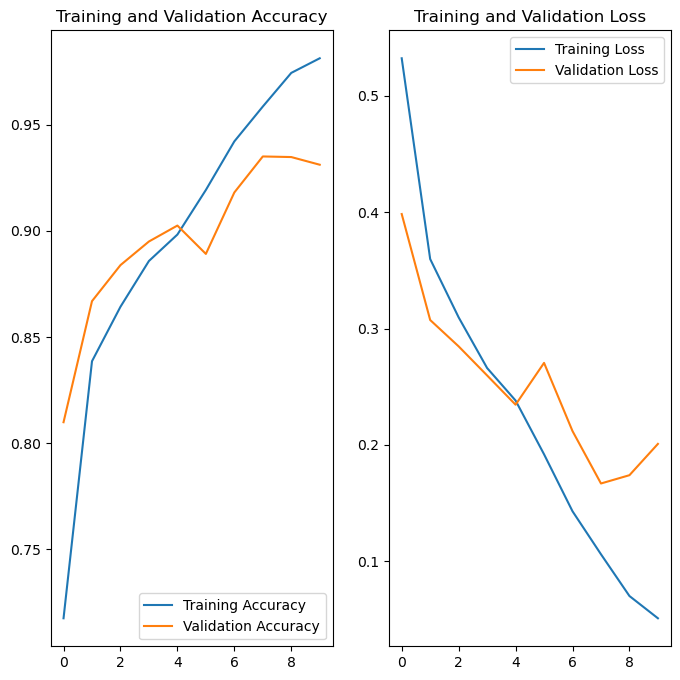

In [40]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# Serialize Model

In [41]:
# note: tf.saved_model.save(model, path_to_dir)
model_version = os.environ.get('VERSION', "1")


model_path = "../models/fingerprint/" + model_version + "/model.savedmodel"
model.save(model_path)

INFO:tensorflow:Assets written to: ../models/fingerprint/1/model.savedmodel/assets


INFO:tensorflow:Assets written to: ../models/fingerprint/1/model.savedmodel/assets


# Test with a sample

In [45]:
fingerprint = scratch_path + "/real/1__M_Left_index_finger.png"

img = tf.keras.utils.load_img(
    fingerprint, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

1/1 [==============================] - 0s 174ms/step
This image most likely belongs to left with a 100.00 percent confidence.
